# Amount of Liscenses Needed as a Percentage of Total Playerbase

## 2) Methods and Results

### Loading in the libraries

In [1]:
library(tidyverse)
library(repr)
library(rvest)
library(tidymodels)
library(stringr)
library(janitor)
options(repr.matrix.max.rows = 6)
neighbors

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────

function (range = c(1L, 10L), trans = NULL) 
{
    new_quant_param(type = "integer", range = range, inclusive = c(TRUE, 
        TRUE), trans = trans, label = c(neighbors = "# Nearest Neighbors"), 
        finalize = NULL)
}
<bytecode: 0x55640a487608>
<environment: namespace:dials>

### Loading in and wrangling the datasets

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players <- read_csv(players_url)
players
sessions <- read_csv(sessions_url)
sessions

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [3]:
sessions_wrangled <- separate(sessions, start_time, c("start_day", "start_month", "start_year", "start_hour", "start_min"))|>
    separate(end_time, c("end_day", "end_month", "end_year", "end_hour", "end_min"))|>
    mutate(start_day = as.numeric(start_day),
           start_month = as.numeric(start_month),
           start_year = as.numeric(start_year),
           start_hour = as.numeric(start_hour),
           start_min = as.numeric(start_min),
           end_day = as.numeric(end_day),
           end_month = as.numeric(end_month),
           end_year = as.numeric(end_year),
           end_hour = as.numeric(end_hour),
           end_min = as.numeric(end_min))

sessions_wrangled

hashedEmail,start_day,start_month,start_year,start_hour,start_min,end_day,end_month,end_year,end_hour,end_min,original_start_time,original_end_time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30,6,2024,18,12,30,6,2024,18,24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,6,2024,23,33,17,6,2024,23,46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25,7,2024,17,34,25,7,2024,17,57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28,7,2024,15,36,28,7,2024,15,57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25,7,2024,6,15,25,7,2024,6,22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20,5,2024,2,26,20,5,2024,2,45,1.71617e+12,1.71617e+12


In [4]:
players_wrangled <- select(players, -individualId, -organizationName) |>
    mutate(experience = as.factor(experience)) |>
    mutate(gender = as.factor(gender))
players_wrangled

experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


### Summary of datasets

In [5]:
total_players <- nrow(players_wrangled)
total_players

[1] 196

There are 196 players playing signed up for the study.

### Visualization of datasets

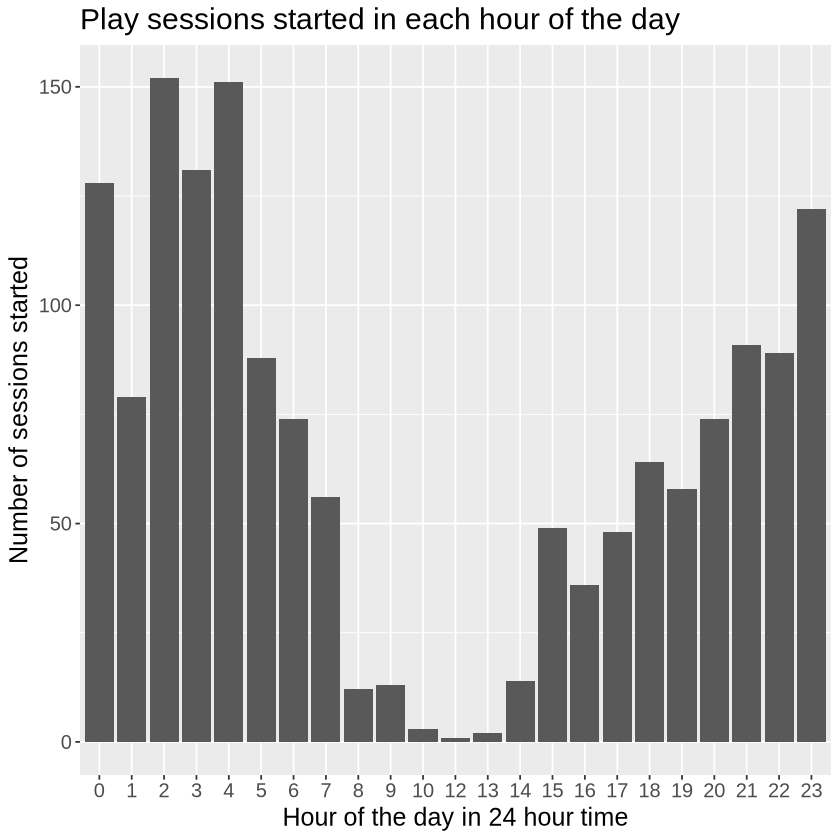

In [6]:
sessions_hours <- mutate(sessions_wrangled, start_hour = as.factor(start_hour)) |>
    ggplot(aes(x = start_hour)) +
    geom_bar() +
    labs(y = "Number of sessions started", x = "Hour of the day in 24 hour time", title = "Play sessions started in each hour of the day") +
    theme(text = element_text(size = 15))
sessions_hours

Fig. 1: This graph shows most sessions start between the evening and early morning. We can expect the largest amount of required liscenses to be around this time range.

### Creating and validating the model

In [7]:
sessions_per_hour <- sessions_wrangled |>
    group_by(start_month, start_day, start_hour) |>
    summarize(number_of_sessions = n()) |>
    arrange(-number_of_sessions) |>
    mutate(percentage_of_players = number_of_sessions/total_players)
sessions_per_hour

`summarise()` has grouped output by 'start_month', 'start_day'. You can
override using the `.groups` argument.


start_month,start_day,start_hour,number_of_sessions,percentage_of_players
<dbl>,<dbl>,<dbl>,<int>,<dbl>
6,27,22,15,0.07653061
7,25,7,13,0.06632653
7,25,6,11,0.05612245
⋮,⋮,⋮,⋮,⋮
9,21,23,1,0.005102041
9,24,6,1,0.005102041
9,26,6,1,0.005102041


In [8]:
init_split <- initial_split(sessions_per_hour, prop = 0.7, strata = number_of_sessions)
sessions_train <- training(init_split)
sessions_test <- testing(init_split)

sessions_recipe <- recipe(number_of_sessions ~ start_hour, data = sessions_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
sessions_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 
sessions_vfold <- vfold_cv(sessions_train, v = 5, strata = number_of_sessions)
k_vals <- tibble(neighbors = seq(from = 1, to = 300, by = 3))
sessions_tune_results <- workflow() |>
    add_recipe(sessions_recipe) |>
    add_model(sessions_tune) |>
    tune_grid(resamples = sessions_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
sessions_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.224367,5,0.1437262,Preprocessor1_Model001
4,rmse,standard,1.218387,5,0.1462277,Preprocessor1_Model002
7,rmse,standard,1.206187,5,0.1548933,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
292,rmse,standard,1.181746,5,0.1614383,Preprocessor1_Model098
295,rmse,standard,1.181807,5,0.1614085,Preprocessor1_Model099
298,rmse,standard,1.181680,5,0.1616124,Preprocessor1_Model100


[1] 55

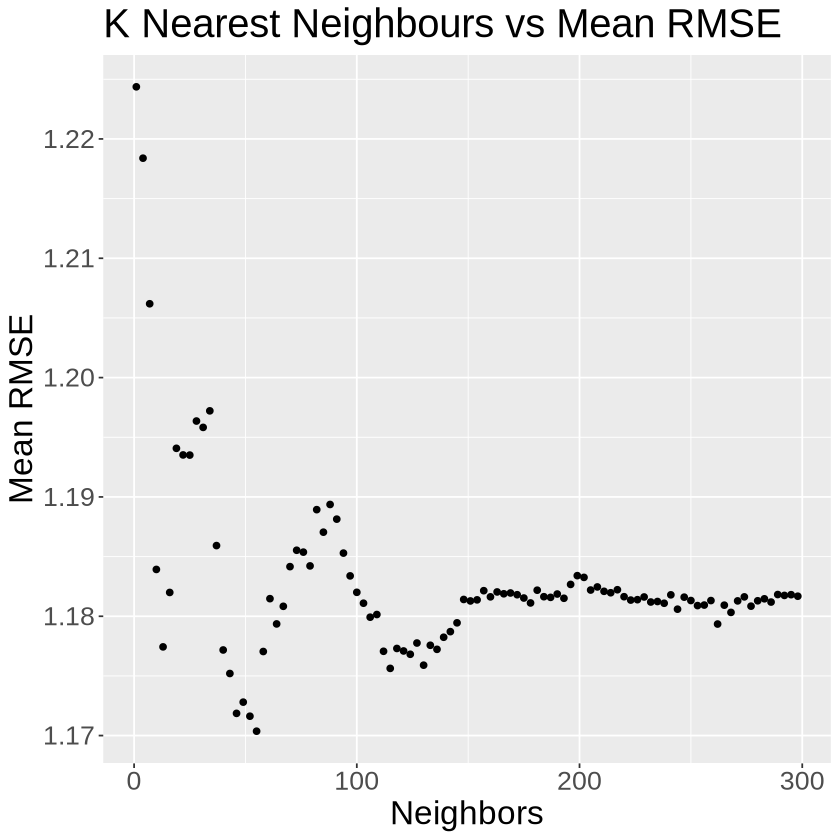

In [9]:
best_k_plot <- ggplot(sessions_tune_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Neighbors", y = "Mean RMSE", title = "K Nearest Neighbours vs Mean RMSE") +
    theme(text = element_text(size = 20))
best_k_plot
sessions_tune_best <- sessions_tune_results |>
    arrange(mean) |>
    select(neighbors) |>
    slice(1) |>
    pull()
sessions_tune_best